In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import gc
import kagglehub
from tqdm import tqdm

from google.colab import files

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from PIL import Image, UnidentifiedImageError, ImageEnhance

In [2]:
files = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip -q tuberculosis-tb-chest-xray-dataset.zip -d tb_dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
100% 663M/663M [00:00<00:00, 1.38GB/s]
100% 663M/663M [00:00<00:00, 1.38GB/s]


In [4]:
path = 'tb_dataset/TB_Chest_Radiography_Database/Normal'

In [5]:
#Path

# path = os.getcwd().replace("notebooks", "") ## Local path directory and cookie cutter ds templete
paths = {
    "normal": 'tb_dataset/TB_Chest_Radiography_Database/Normal',
    "tuberculosis": 'tb_dataset/TB_Chest_Radiography_Database/Tuberculosis'
}

In [6]:
normal = {
    'category_name': 'normal',
    'load_command': [f"{paths['normal']}" + "/" + f'{i}' for i in os.listdir(paths['normal'])]
}

tuberculosis = {
    'category_name': 'tuberculosis',
    'load_command': [f"{paths['tuberculosis']}" + "/" + f'{i}' for i in os.listdir(paths['tuberculosis'])]
}

categories = [normal, tuberculosis]

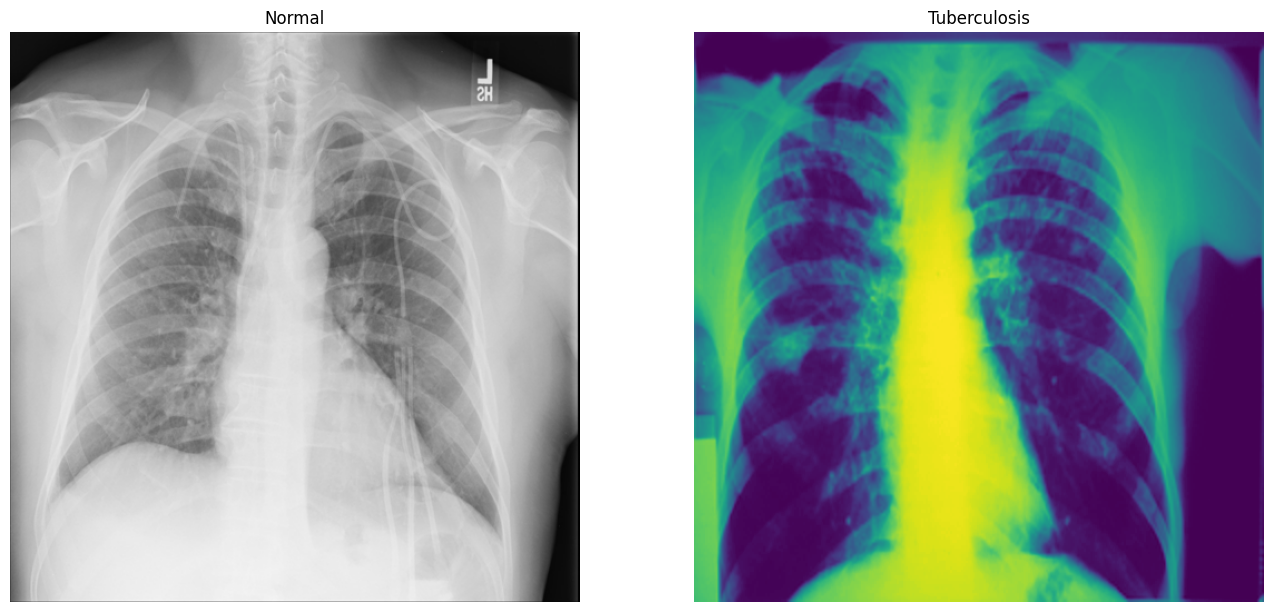



Size of the image
Category: normal
(512, 512)


Size of the image
Category: tuberculosis
(512, 512)


In [7]:
img1 = Image.open(f"{normal['load_command'][0]}")
img2 = Image.open(f"{tuberculosis['load_command'][0]}")

def plot_image(img):
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap = 'gray')
  plt.axis("off")
  plt.show()

plt.figure(figsize=(25, 10))
for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.imshow([img1, img2][i])
    plt.title(["Normal", "Tuberculosis"][i])
    plt.axis("off")
plt.show()

for size,name in zip([img1.size, img2.size],categories):
    print('\n')
    print(f"Size of the image\nCategory: {name['category_name']}")
    print(size)

In [8]:
def load_images(img_vector, img_shape=tuple):
  X,y = [],[]

  for vector in img_vector:
    # Calculate total number of images to process for the progress bar
    total_images = len(vector['load_command'])

    # Create progress bar
    progress_bar = tqdm(total=total_images, desc="Loading images", unit="img")

    for images in vector['load_command']:
      img = cv2.imread(images, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, img_shape)
      img = cv2.medianBlur(img, 7)
      img = img.squeeze()
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      img = np.asarray(img)
      X.append(img)
      y.append(vector['category_name'])
      # Update progress bar
      progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

  return X, y

In [9]:
# Inceoption_V3 load pipeline
X, y = load_images(categories, (299, 299)) #Inception_V3 input
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Loading images: 100%|██████████| 700/700 [00:07<00:00, 97.15img/s] 


In [10]:
X[0].shape

(299, 299, 3)

In [11]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)


category_dict = {
    "normal": 0,
    "tuberculosis": 1,
}

y_train = [category_dict[i] for i in y_train]
y_test = [category_dict[i] for i in y_test]
y_val = [category_dict[i] for i in y_val]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [19]:
model = Sequential()
# model.add(Rescaling(1./255))
model.add(RandomFlip("horizontal_and_vertical"))
model.add(RandomZoom(
    height_factor = (-0.5,0.5),
    width_factor = (-0.5,0.5),
))
model.add(RandomRotation(0.5))
# model.add(RandomBrightness([-0.2,0.2]))
model.add(inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3)))
model.add(Conv2D(128, (1,1)))
model.add(Conv2D(256, (1,1)))
model.add(Conv2D(512, (1,1)))
model.add(MaxPooling2D((2,2), padding = "same"))
model.add(SpatialDropout2D(0.4))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(2, activation = "softmax"))

In [20]:
callbacks = [
    EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3, min_lr = 0.0001)
]

In [21]:
model.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adadelta(learning_rate=0.05), metrics = ["accuracy", "categorical_accuracy"])
history_inception = model.fit(X_train, y_train, epochs = 100 , batch_size = 50, validation_data = (X_val, y_val), callbacks = callbacks)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 56s 237ms/step - accuracy: 0.5110 - categorical_accuracy: 0.5110 - loss: 0.9736 - val_accuracy: 0.5143 - val_categorical_accuracy: 0.5143 - val_loss: 0.6889 - learning_rate: 0.0500
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.5625 - categorical_accuracy: 0.5625 - loss: 0.8506 - val_accuracy: 0.8405 - val_categorical_accuracy: 0.8405 - val_loss: 0.5576 - learning_rate: 0.0500
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.6621 - categorical_accuracy: 0.6621 - loss: 0.7399 - val_accuracy: 0.2940 - val_categorical_accuracy: 0.2940 - val_loss: 1.4246 - learning_rate: 0.0500
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.7543 - categorical_accuracy: 0.7543 - loss: 0.6161 - val_accuracy: 0.7655 - val_categorical_accuracy: 0.7655 - val_loss: 0.6326 - learning_rate: 0.0500
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.8138 - categorical_accuracy: 0.8138 - loss: 0.5363 - val

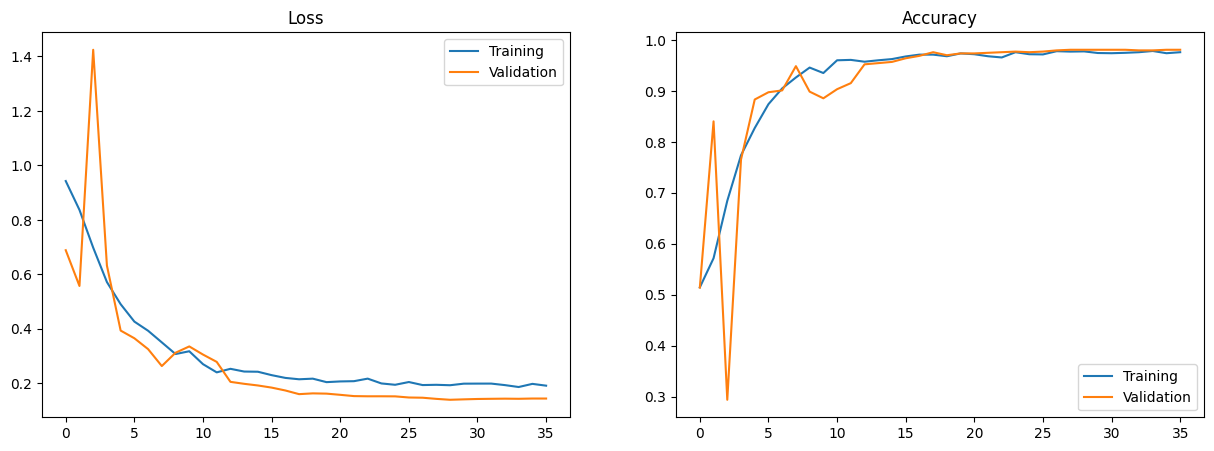

In [22]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.lineplot(ax = ax[0], data = history_inception.history["loss"], label = "Training")
sns.lineplot(ax = ax[0], data = history_inception.history["val_loss"], label = "Validation")
ax[0].set_title("Loss")
sns.lineplot(ax = ax[1], data = history_inception.history["accuracy"], label = "Training")
sns.lineplot(ax = ax[1], data = history_inception.history["val_accuracy"], label = "Validation")
ax[1].set_title("Accuracy")
plt.show()

In [23]:
save_model = {
    "model": model,
    "history": history_inception
}

In [25]:
model.save("inception_model.keras")

In [26]:
def save_variables(variables, filename):
  with open(filename, 'wb') as file:
      pickle.dump(variables, file)
  print(f"Variables saved to {filename}.")

In [27]:
# save_variables(save_variables, "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/processed/variables.pkl")
save_variables(save_model, "inception_model.pkl")

Variables saved to inception_model.pkl.
